# 3. 주성분 분석

In [ ]:
# 데이터셋 생성을 위한 추가 코드
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3)) # 3D 데이터 초기화
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5 # 타원형
X += 0.28 * np.random.randn(m, 3) # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2] # 약간 이동

In [ ]:
X_centered = X- X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [ ]:
# 첫 두개의 주성분으로 정의된 평면에 훈련 세트를 투영하는 코드
W2 = Vt[:2].T
X2D = X_centered @ W2

In [ ]:
print(X[:30])
print(X2D[:30])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

# ****** 이렇게 확인하는 과정이 아주 중요
print(pca.components_)
print( )
print(pca.explained_variance_ratio_)  # 설명된 분산 비율

[[ 0.67857588  0.70073508  0.22023881]
 [ 0.72817329 -0.6811147  -0.07646185]]

[0.7578477  0.15186921]


In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False) # *FutureWarning을 안 뜨게 하려면 parser='auto'를 추가
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.95)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# n_components=d로 설정하여 PCA를 다시 실행
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_ # 실제 주성분 개수는 훈련 중에 결정되며 n_components_ 속성에 저장

154

In [ ]:
# 설명된 분산의 비율
pca.explained_variance_ratio_.sum()

0.9501960192613035

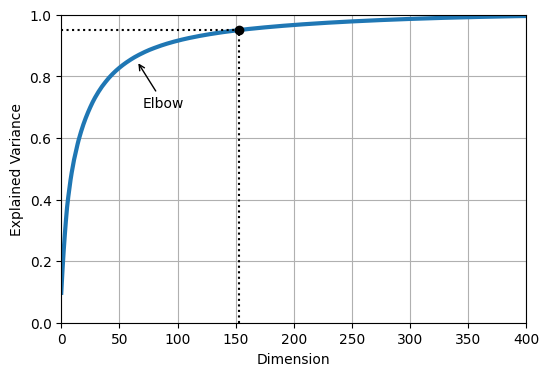

In [ ]:
# 설명된 분산을 차원 수에 대한 함수로 그리기
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimension")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))

plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))

param_distrib = {
    'pca__n_components':np.arange(10,80),
    'randomforestclassifier__n_estimators':np.arange(50,500)}

rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [ ]:
X_recovered = pca.inverse_transform(X_reduced)
print(X_recovered)

[[ 2.64687454e-14 -5.81302016e-13 -1.79499509e-13 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.64609603e-15 -1.67996410e-13 -5.11041518e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.28377776e-15  8.10470042e-14 -9.30589413e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 8.88183138e-15 -1.81564119e-13  6.04953780e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.07364675e-16  4.46563152e-14 -5.45605406e-15 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.73667409e-15  2.11325954e-14  1.25009063e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [ ]:
rnd_pca = PCA(n_components=154, svd_solver='randomized', random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)
print(X_reduced)

[[ 123.93258864 -312.67426198  -24.51405174 ...  -62.00213296
    -8.8147422   -66.93993166]
 [1011.71837586 -294.85703831  596.33956108 ...  -24.52514836
    26.58534428   16.99077095]
 [ -51.84960804  392.17315289 -188.50974941 ...   -8.99144972
    -2.99473092   56.93622984]
 ...
 [-178.0534496   160.0782111  -257.61308227 ...   35.30439525
    -2.75142691   23.97581712]
 [ 130.60607212   -5.59193632  513.85867376 ...  -15.84132904
   -18.38612585   39.40742042]
 [-173.43595246  -24.71880228  556.01889398 ...   29.62816702
   -52.61652274   27.99524134]]


In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)
print(X_reduced)

[[ 123.93240015  312.67412765   24.51396855 ...   55.02414967
   -18.82319306   57.12605157]
 [1011.71883902  294.85791533 -596.3396284  ...   40.79115354
   -28.52753525  -32.93944347]
 [ -51.84977972 -392.17395257  188.50798593 ...   18.5109603
   -75.96611653   -7.67736302]
 ...
 [-178.0534095  -160.07838721  257.61233558 ...  -57.3811145
     6.70673288  -54.26797595]
 [ 130.60654125    5.59174593 -513.85834969 ...  -22.43044205
    12.51568244  -36.3004746 ]
 [-173.43566358   24.71937319 -556.01892138 ...  -48.33215133
    19.2936437   -30.58306681]]


In [ ]:
filename = 'my_mnist.mmap'
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train # 대신 반복을 사용해 데이터를 한 정크씩 저장할 수 있음
X_mmap.flush()

In [ ]:
X_mmap = np.memmap(filename, dtype='float32', mode='readonly').reshape(-1,784)
batch_size = X_mmap.shape[0] // n_batches

inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

# 4. 랜덤 투영

In [ ]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, e = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps = e)
d

7300

In [ ]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d,n) / np.sqrt(d) # 표준편차 - 분산의 제곱근

X = np.random.randn(m,n) # 가짜 데이터 생성
X_reduced = X @ P.T

In [ ]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=e, random_state=42)
X_reduced_2 = gaussian_rnd_proj.fit_transform(X) # 이전 결과와 동일

# 정말 동일한 결과가 나오는지 확인
are_close = np.allclose(X_reduced, X_reduced_2, atol=1e-7)
are_close

True

In [ ]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

KeyboardInterrupt: 

# 5. 지역 선형 임베딩

In [ ]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

In [ ]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2],

c=t, cmap=darker_hot)

ax.view_init(10, -70)
plt.show()

In [ ]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)
plt.show()

# 연습문제 9

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

In [ ]:
from  sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf.fit(X_train, y_train)

CPU times: user 1min 2s, sys: 226 ms, total: 1min 3s
Wall time: 1min 20s


RandomForestClassifier(random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [ ]:
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: user 2min 45s, sys: 297 ms, total: 2min 45s
Wall time: 3min 13s


RandomForestClassifier(random_state=42)

In [ ]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

CPU times: user 3min 40s, sys: 518 ms, total: 3min 41s
Wall time: 3min 46s


SGDClassifier(random_state=42)

In [ ]:
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.874

In [ ]:
sgd_clf_with_pca = SGDClassifier(random_state=42)
%time sgd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: user 1min 15s, sys: 310 ms, total: 1min 16s
Wall time: 1min 49s


SGDClassifier(random_state=42)

In [ ]:
y_pred = sgd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8959

# 연습문제 10. MNIST에 t-SNE 적용하기

In [ ]:
X_sample, y_sample = X_train[:5000], y_train[:5000]

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=42)
X_reduced = tsne.fit_transform(X_sample)

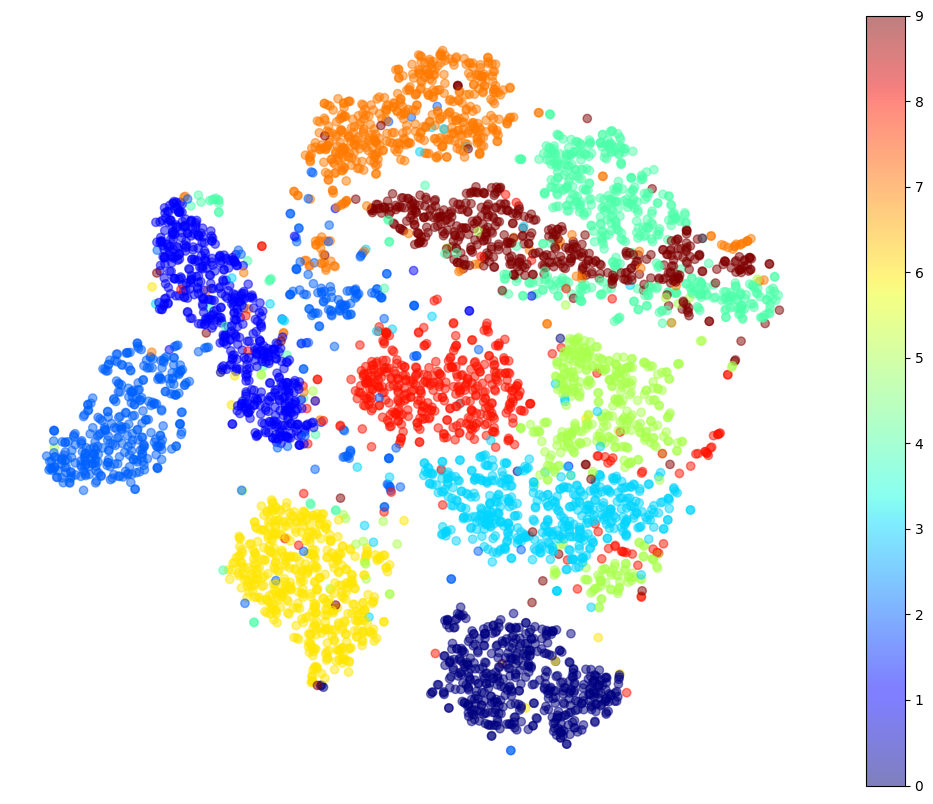

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:,0], X_reduced[:,1],
            c=y_sample.astype(np.int8), cmap='jet', alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
'''from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.4, images=None, figsize=(13,10)):
  X_normalized = MinMaxScaler().fit_transform(X)
  neighbors = np.array([[10.,10.]])
  plt.figure(figsize=figsize)
  cmap = plt.cm.jet
  digits = np.unique(y)

  for digit in digits:
    plt.scatter(X_normalized[y == digit,0], X_normalized[y==digit,1],
                c=[cmap(float(digit)/9)], alpha=0.5)

  plt.axis('off')
  ax = plt.gca()

   # Adding the title
  plt.title("Jeongmin Ahn 2013753 Statistics")

  for index, image_coord in enumerate(X_normalized):
    closet_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
    if closet_distance > min_distance:
      neighbors = np.r_[neighbors, [image_coord]]
      if images is None:
        plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                 color=cmap(float(y[index])/9),
                 fontdict={'weight':'bold', 'size':16})

      else:
        image = images[index].reshape(28,28)
        imagebox = AnnotationBbox(OffsetImage(image, cmap='binary'),
                                  image_coord)
        ax.add_artist(imagebox)'''

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
  X_normalized = MinMaxScaler().fit_transform(X)
  neighbors = np.array([[10., 10.]])
  plt.figure(figsize=figsize)
  cmap = plt.cm.jet
  digits = np.unique(y)

  for digit in digits:
    plt.scatter(X_normalized[y==digit, 0], X_normalized[y==digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis('off')
    ax = plt.gca()

    # Adding the title
    plt.title("Jeongmin Ahn 2013753 Statistics")


    for index, image_coord in enumerate(X_normalized):
      closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
      if closest_distance > min_distance:
        neighbors = np.r_[neighbors, [image_coord]]
        if images is None:
          plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                   color=cmap(float(y[index]) / 9),
                   fontdict={'weight':'bold', 'size':16})
        else:
          image = images[index].reshape(28, 28)
          imagebox = AnnotationBbox(OffsetImage(image, cmap='binary'),
                                    image_coord)
          ax.add_artist(imagebox)


In [ ]:
plot_digits(X_reduced, y_sample)

In [ ]:
plot_digits(X_reduced, y_sample, images=X_sample, figsize=(35,25))